In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [61]:
# Define the directory path
directory = "DE_results"

In [50]:
def volcano_plot(file_path):
    """
    Reads a filtered CSV file and plots a volcano plot, labeling the top 10 most extreme genes.

    Parameters:
    - file_path (str): Path to the filtered CSV file.
    """
    # Read CSV file
    df = pd.read_csv(file_path, sep=",")

    # Ensure required columns exist
    if "logFC" not in df.columns or "PValue" not in df.columns or "gene_symbol" not in df.columns or "FDR" not in df.columns:
        print(f"Skipping {file_path}: Missing required columns.")
        return
    
    # Compute -log10 P-values
    df["-logQ"] = -np.log10(df["PValue"])

    # Sort by the absolute value of logFC and select the top 10 most extreme genes
    df["abs_logFC"] = df["logFC"].abs()  # Calculate absolute logFC
    top_10_extreme = df.nlargest(10, "abs_logFC")

    # Split into significant and non-significant groups
    significant = df[abs(df["logFC"]) >= LOG_FOLD_CHANGE]
    non_significant = df[abs(df["logFC"]) < LOG_FOLD_CHANGE]

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))

    # Non-significant points
    sns.scatterplot(x=non_significant["logFC"], y=non_significant["-logQ"], color="orange", alpha=0.5, s=10, ax=ax)

    # Significant points
    sns.scatterplot(x=significant["logFC"], y=significant["-logQ"], color="blue", s=10, ax=ax)

    # Highlight and label top 10 most extreme genes
    sns.scatterplot(x=top_10_extreme["logFC"], y=top_10_extreme["-logQ"], color="red", s=15, ax=ax)

    # Prepare text labels
    texts = []
    for _, row in top_10_extreme.iterrows():
        text = ax.text(row["logFC"], row["-logQ"], row["gene_symbol"], fontsize=8, ha="right")
        texts.append(text)

    # Adjust label positions to avoid overlap
    adjust_text(texts, ax=ax, only_move={"points": "xy", "text": "xy"}, arrowprops=dict(arrowstyle="->", color="gray"))

    # Labels and styling
    ax.set_xlabel("log2 Fold Change")
    ax.set_ylabel("-log10 P-Value")
    title = os.path.basename(file_path).replace("_", " ").replace(".csv", "")
    ax.set_title(title)
    
    plt.show()

In [51]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5

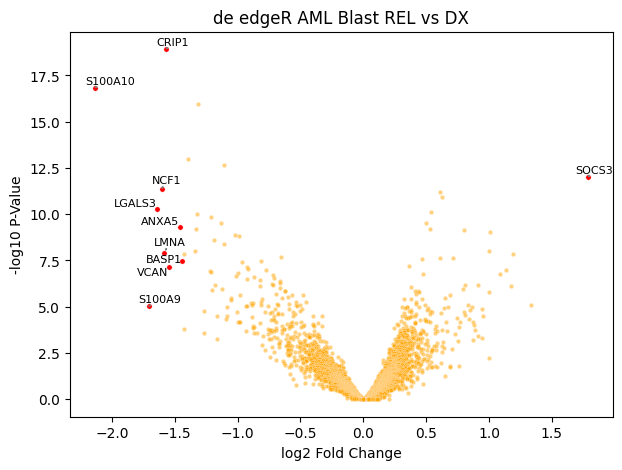

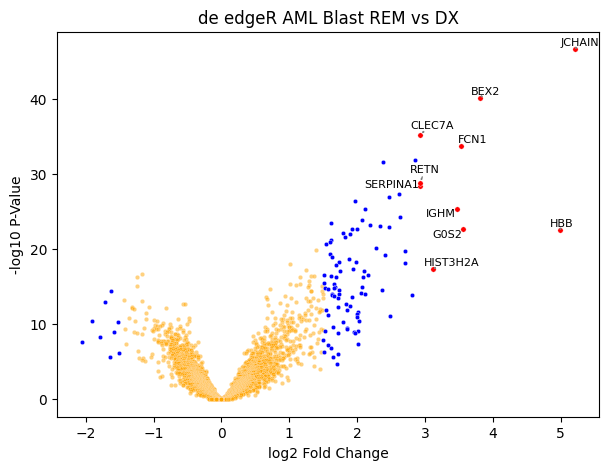

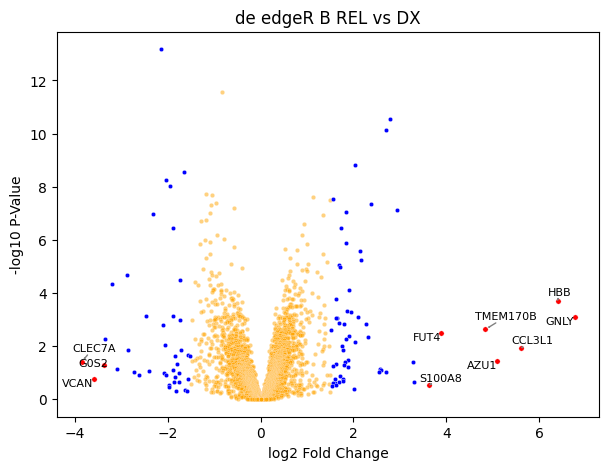

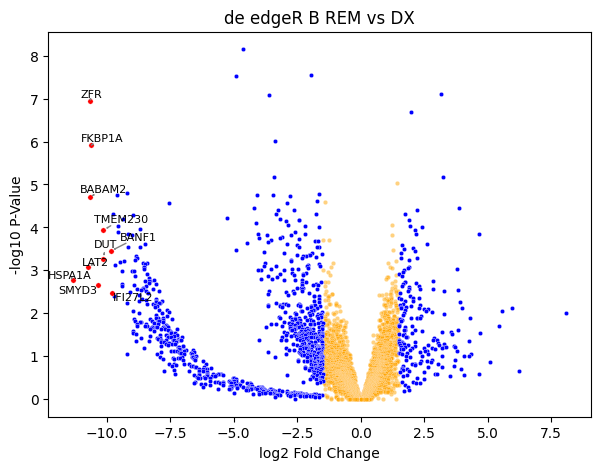

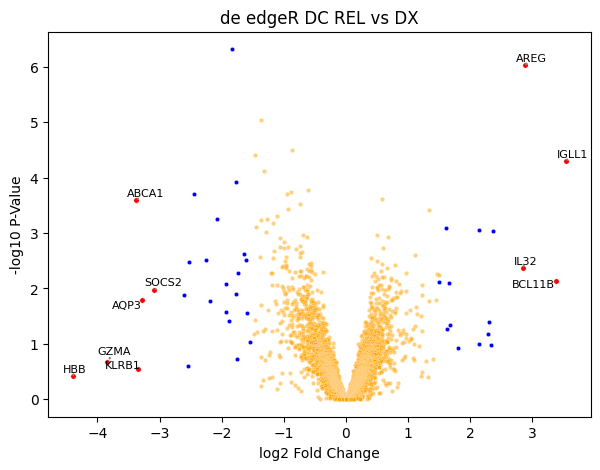

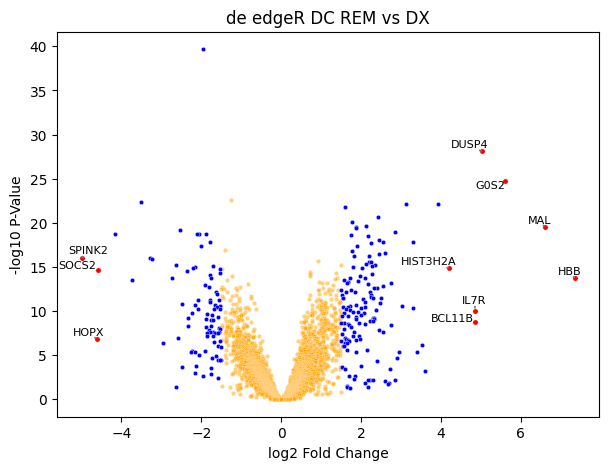

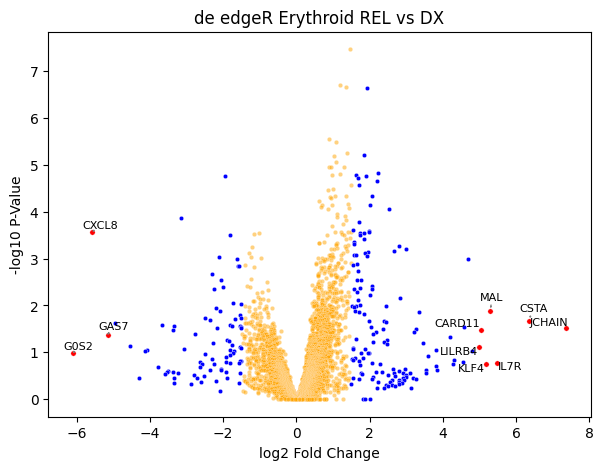

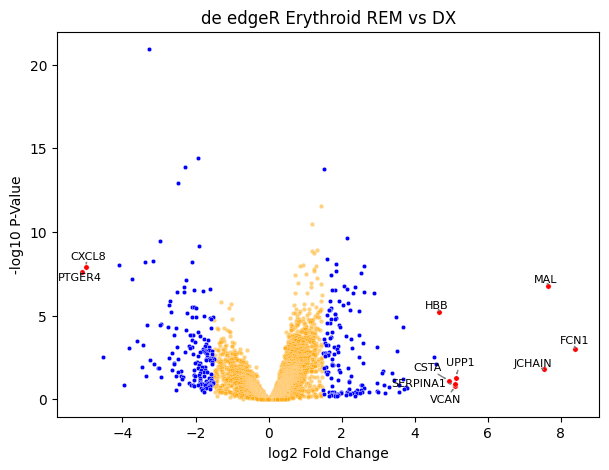

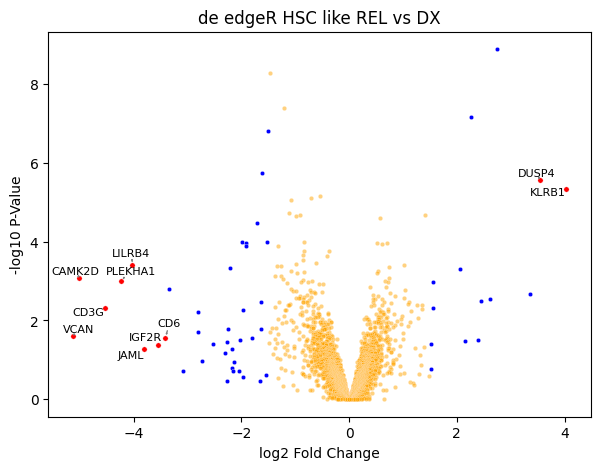

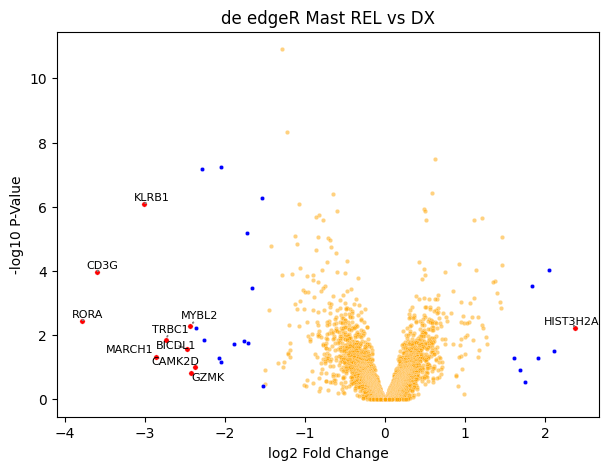

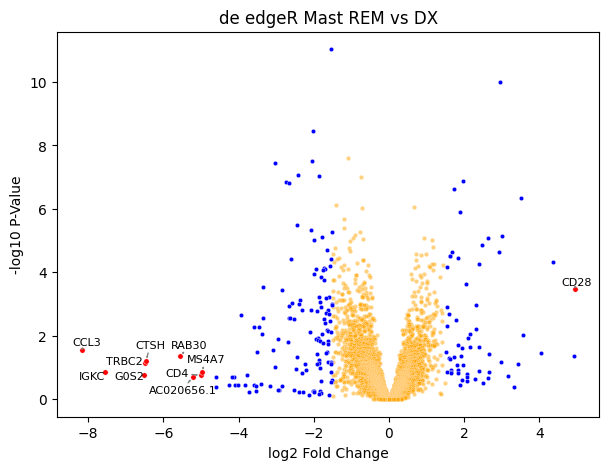

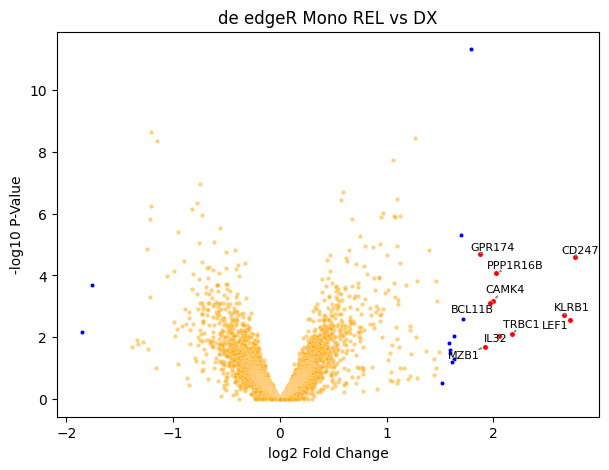

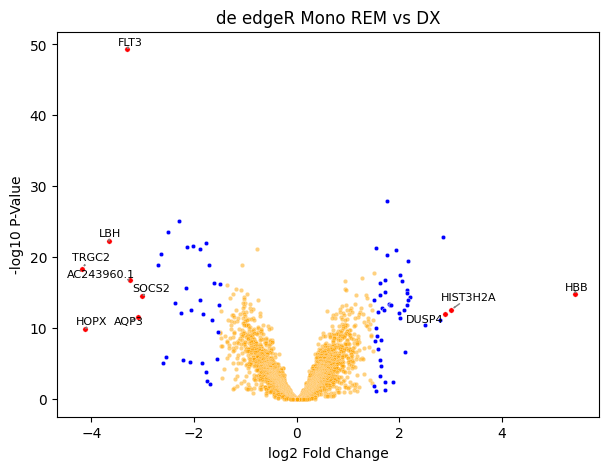

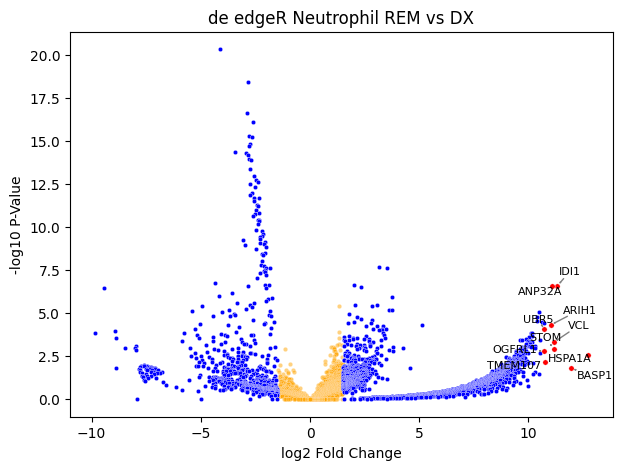

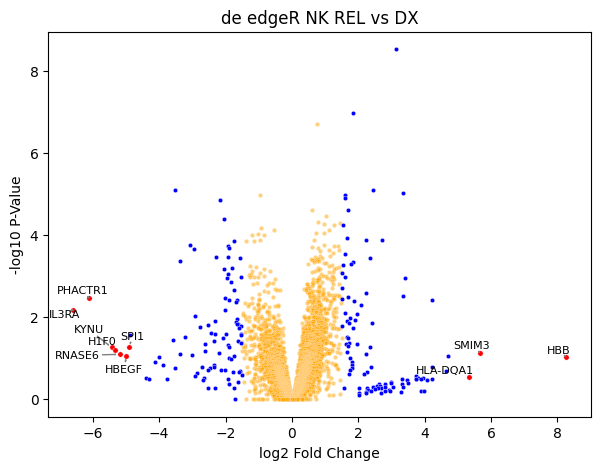

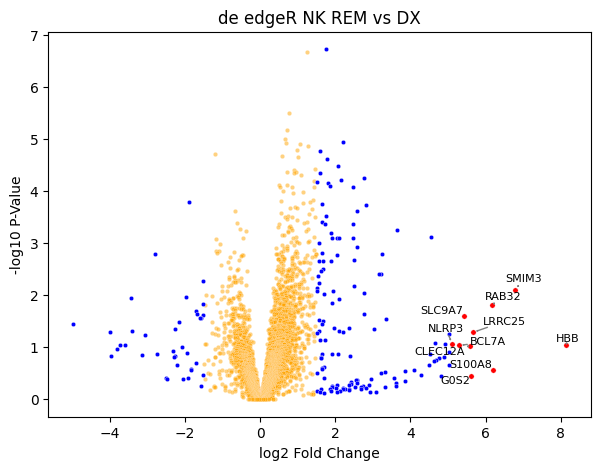

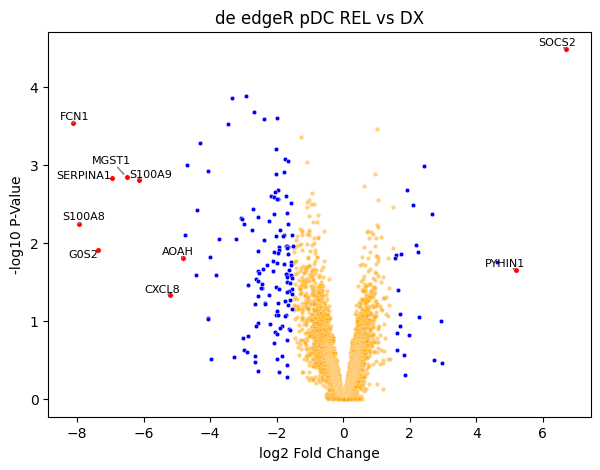

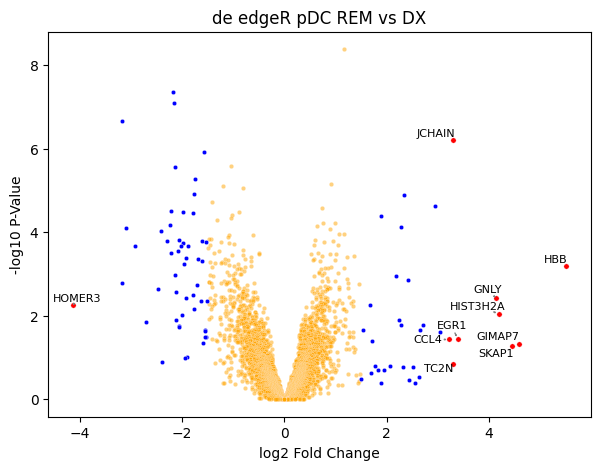

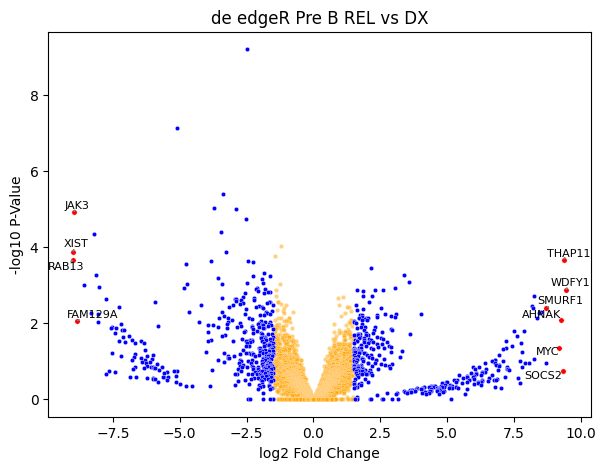

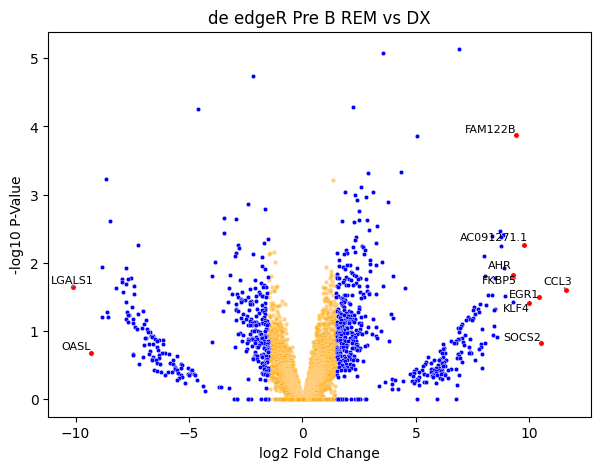

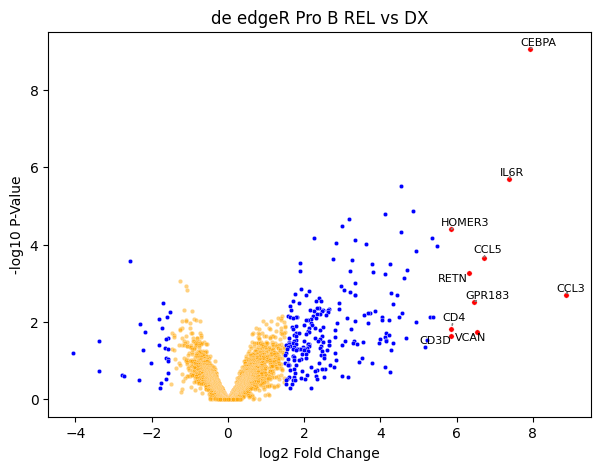

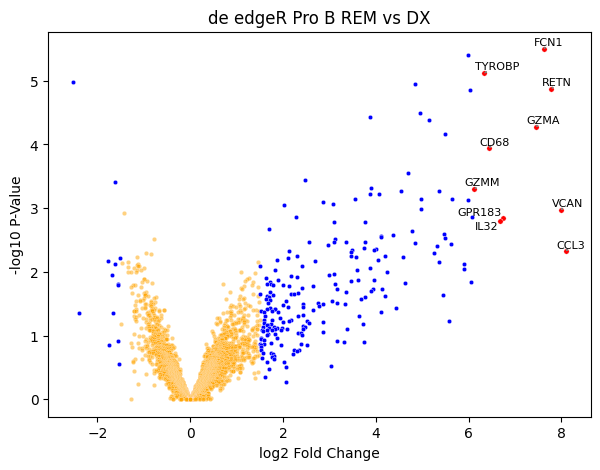

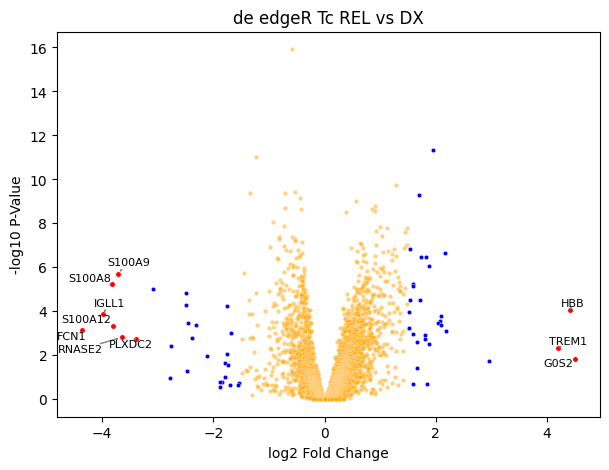

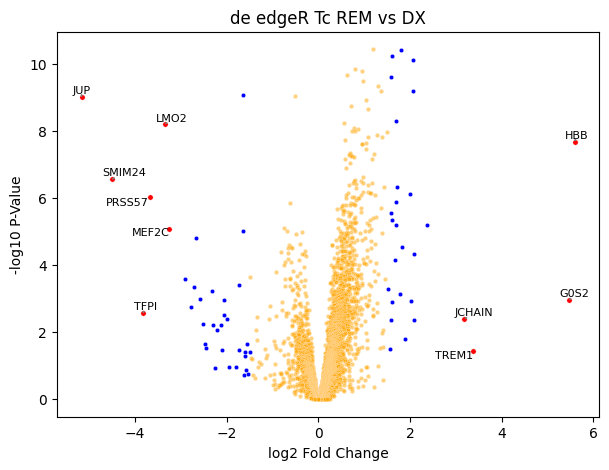

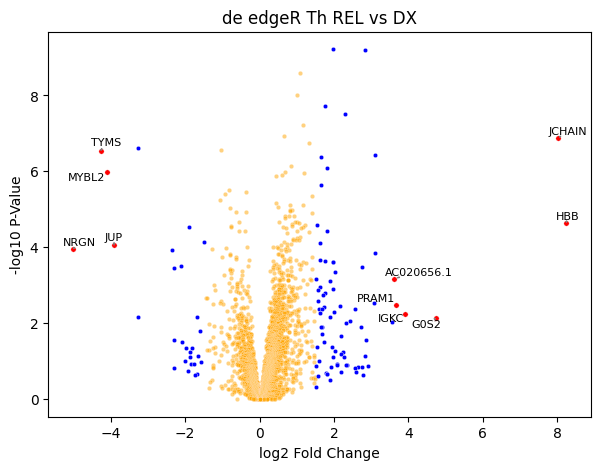

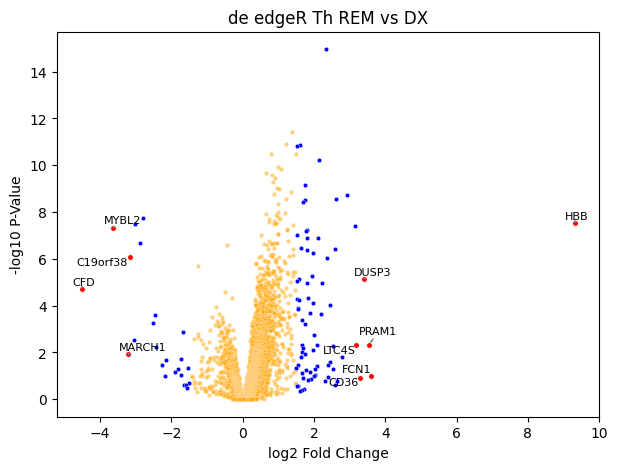

In [52]:
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]

# Run for all files
for file in files:
    volcano_plot(file)

In [59]:
def find_top_genes_in_csv(directory, logfc_threshold=1, pvalue_threshold=0.05, top_n=10):
    """
    Reads CSV files in the given directory, filters for genes with high -log10(p-value) and |logFC|, 
    then reports the top N genes based on these criteria across all files, with the condition and cell type.

    Parameters:
    - directory (str): Path to the directory containing CSV files.
    - logfc_threshold (float): The minimum absolute logFC value to consider.
    - pvalue_threshold (float): The p-value threshold below which to consider genes.
    - top_n (int): The number of top genes to report.
    """
    top_genes = []
    
    # Iterate through each CSV file in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]
    for file in files:
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Clean column names and ensure required columns exist
        df.columns = df.columns.str.strip()
        if not {"logFC", "PValue", "gene_symbol", "cell_type"}.issubset(df.columns):
            print(f"Skipping {file}: Missing required columns.")
            continue
        
        # Compute -log10(P-value) and add it to the dataframe
        df["-logQ"] = -np.log10(df["PValue"])
        
        # Extract condition and cell type from the file name (optional)
        condition_pair = file.split('_')  # Assuming filename structure like 'Condition1_Condition2.csv'
        if len(condition_pair) >= 2:
            condition = f'{condition_pair[0]} vs {condition_pair[1]}'
        else:
            condition = "Unknown vs Unknown"
        
        # Filter for genes with |logFC| > logfc_threshold and p-value < pvalue_threshold
        filtered_df = df[(df["PValue"] < pvalue_threshold) & (df["logFC"].abs() > logfc_threshold)]
        
        # Sort by -log10(p-value) and then by logFC (descending for both)
        sorted_df = filtered_df.sort_values(by=["-logQ", "logFC"], ascending=[False, False])
        
        # Select top N genes from the sorted dataframe
        for _, row in sorted_df.head(top_n).iterrows():
            top_genes.append([row["gene_symbol"], row["logFC"], row["PValue"], row["-logQ"], row["cell_type"], condition])

    # Convert the list of top genes to a DataFrame for easier viewing
    top_genes_df = pd.DataFrame(top_genes, columns=["Gene", "logFC", "PValue", "-logQ", "Cell Type", "Condition"])
    
    # Display the top genes sorted by the criteria
    return top_genes_df

In [62]:
top_genes_df = find_top_genes_in_csv(directory)

         Gene     logFC        PValue      -logQ            Cell Type  \
0       CRIP1 -1.570711  1.209067e-19  18.917550  AML_Blast_REL_vs_DX   
1     S100A10 -2.137531  1.466758e-17  16.833642  AML_Blast_REL_vs_DX   
2       CAPN2 -1.318244  1.040022e-16  15.982957  AML_Blast_REL_vs_DX   
3      SAMHD1 -1.391721  9.837008e-14  13.007137  AML_Blast_REL_vs_DX   
4        CAST -1.107163  2.161911e-13  12.665162  AML_Blast_REL_vs_DX   
..        ...       ...           ...        ...                  ...   
255  SERPINB1  1.486521  3.223606e-11  10.491658         Th_REM_vs_DX   
256  SERPINB6  2.148627  6.105101e-11  10.214307         Th_REM_vs_DX   
257    GNPTAB  1.072963  1.412372e-10   9.850051         Th_REM_vs_DX   
258    LGALS9  1.745797  7.031597e-10   9.152946         Th_REM_vs_DX   
259   MT-ATP8  1.025889  1.021773e-09   8.990646         Th_REM_vs_DX   

            Condition  
0    DE vs results/de  
1    DE vs results/de  
2    DE vs results/de  
3    DE vs results/de  
4  

In [64]:
top_genes_df.head(50)

,Gene,logFC,PValue,-logQ,Cell Type,Condition
0,CRIP1,-1.570711,1.209067e-19,18.917550,AML_Blast_REL_vs_DX,DE vs results/de
1,S100A10,-2.137531,1.466758e-17,16.833642,AML_Blast_REL_vs_DX,DE vs results/de
2,CAPN2,-1.318244,1.040022e-16,15.982957,AML_Blast_REL_vs_DX,DE vs results/de
3,SAMHD1,-1.391721,9.837008e-14,13.007137,AML_Blast_REL_vs_DX,DE vs results/de
4,CAST,-1.107163,2.161911e-13,12.665162,AML_Blast_REL_vs_DX,DE vs results/de
5,SOCS3,1.787078,1.016300e-12,11.992978,AML_Blast_REL_vs_DX,DE vs results/de
6,NCF1,-1.604446,4.165348e-12,11.380349,AML_Blast_REL_vs_DX,DE vs results/de
7,LGALS3,-1.638616,5.258844e-11,10.279110,AML_Blast_REL_vs_DX,DE vs results/de
8,MARCH1,-1.320967,9.588442e-11,10.018252,AML_Blast_REL_vs_DX,DE vs results/de
9,LILRB4,-1.210351,1.421594e-10,9.847225,AML_Blast_REL_vs_DX,DE vs results/de
